In [2]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


In [1]:
import transformers
print(transformers.__version__)

4.52.4


In [3]:
from openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm
import os
import pandas as pd

In [10]:
train_data, test_data = read_processed_data(augmented=False, balanced=False)
data = pd.concat([train_data, test_data], ignore_index=True)

In [11]:
NO_SAMPLES = 10

data = data.sample(n=NO_SAMPLES)

In [1]:
"""
Models (intelligence,speed - cost per 1000 requests - requests per 1$)
o3 (5,1 - $0.754 - 1,326): o3-2025-04-16 \
GPT-4.1 (4,3  - $0.754 - 1,326): gpt-4.1-2025-04-14 \
GPT-4o mini (2,4 - $0.4147 - 2,411): gpt-4o-mini-2024-07-18 \
GPT-4.1 nano (2,5 - $0.0377 - 26,525): gpt-4.1-nano-2025-04-14 \
"""

'\nModels (intelligence, speed)\no3 (5,1 - 1000 requests: $0.754 - 1$ = 1,326 requests): o3-2025-04-16 GPT-4.1 (4,3  - 1000 requests: $0.754 - 1$ = 1,326 requests): gpt-4.1-2025-04-14 GPT-4o mini (2,4 - 1000 requests: $0.4147 - 1$ = 2,411 requests): gpt-4o-mini-2024-07-18 GPT-4.1 nano (2,5 - 1000 requests: $0.0377 - 1$ = 26,525 requests): gpt-4.1-nano-2025-04-14 '

In [12]:
prompts = [
    {
        "text": row["text"],
        "label_orig": "real" if row["label"] == 0 else "fake"
    }
    for _, row in data.iterrows()
]

client = OpenAI(api_key=os.getenv("OPENAI_SECRET_KEY"))

load_dotenv()

client = OpenAI(api_key=os.getenv("OPENAI_SECRET_KEY"))
responses = []

for prompt in tqdm(prompts, desc="Processing prompts"):
    response = client.responses.create(
        model="gpt-4.1-nano-2025-04-14",
        input = [
            {
                "role": "system",
                "content": "You are a fake news detector. Respond with only 'real' or 'fake'."
            },
            {
                "role": "user",
                "content": prompt["text"]
            },
        ],
        temperature = 0.3,
    )

    label_pred = response.output_text.lower()
    responses.append(
        {
            "prompt": prompt["text"], 
            "label_original": prompt["label_orig"], 
            "label_predicted": label_pred
        }
    )

Processing prompts: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [22]:
y_true = [response["label_original"] for response in responses]
y_pred = [response["label_predicted"] for response in responses]


# Sanity check: Ensure the LLM output contains exactly one label per sample, and only valid labels ('real' or 'fake').
if all(item in {"real", "fake"} for item in y_pred) and len(y_pred) == NO_SAMPLES:
    print("Successfully labeled all samples provided")
else:
    print(f"ERROR: Only labeled {NO_SAMPLES - sum(item not in {'real', 'fake'} for item in y_pred)} / {NO_SAMPLES} samples correctly")

ERROR: Only labeled 9 / 10 samples correctly


Classification Report:
              precision    recall  f1-score   support

        fake       0.75      0.86      0.80         7
        real       0.50      0.33      0.40         3

    accuracy                           0.70        10
   macro avg       0.62      0.60      0.60        10
weighted avg       0.68      0.70      0.68        10


Overall Metrics:
Accuracy       : 0.7000
Precision (avg): 0.6750
Recall    (avg): 0.7000
F1 Score  (avg): 0.6800



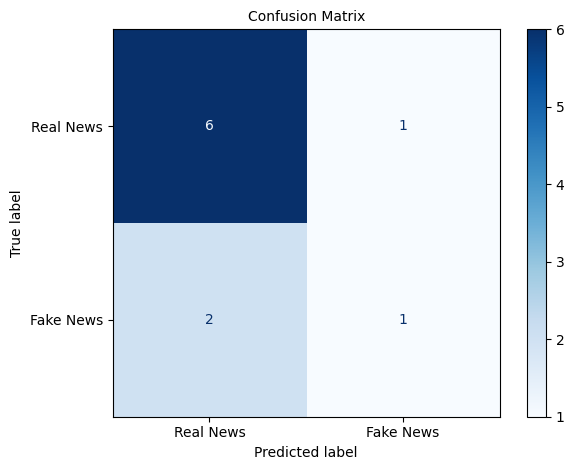

In [16]:
evaluate_model(y_true, y_pred)